<a href="https://colab.research.google.com/github/soffiyahabass1/ArewaDS-Deep-Learning/blob/main/Part_1_Deep_Learning_with_Pytorch/week5/week_5_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """

    data_path = Path("data/")
    image_path = data_path / destination


    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)


        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:

train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
from torchvision import datasets, transforms

from torch.utils.data import DataLoader

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
import torchvision
import torch

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:

auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x786e4fd5e2d0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


In [ ]:
!pip install torchinfo

In [ ]:

 import torchinfo
 from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:

for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      return results

In [ ]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()


results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
[INFO] Total training time: 4.595 seconds


In [ ]:
import matplotlib.pyplot as plt


def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

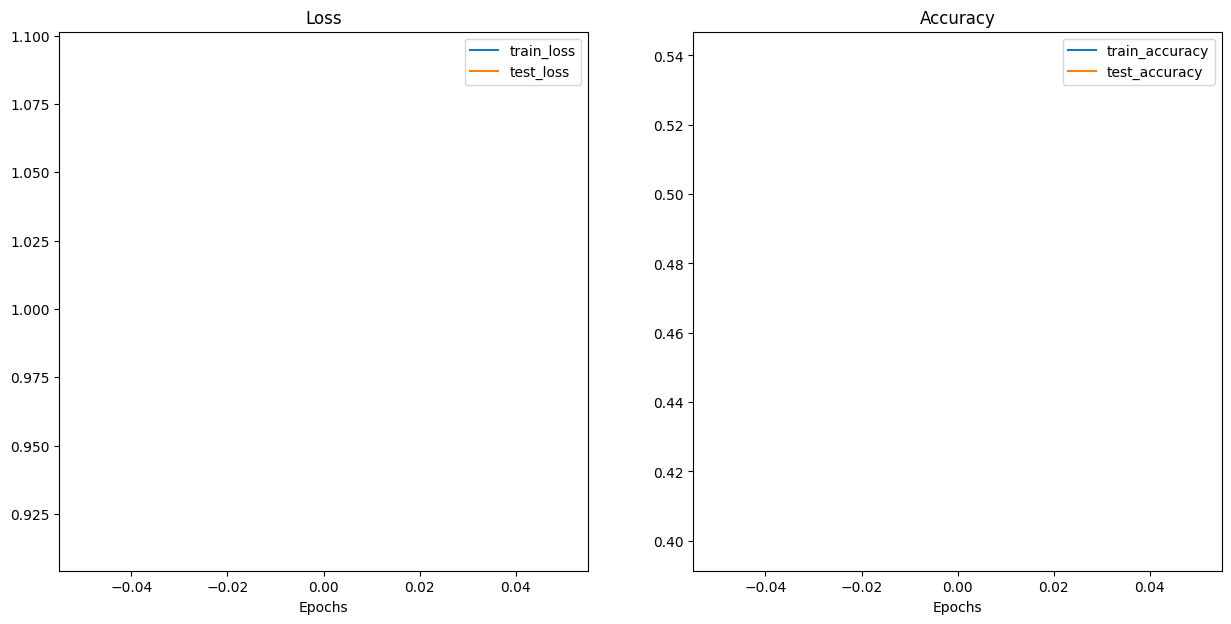

In [ ]:
plot_loss_curves(results)

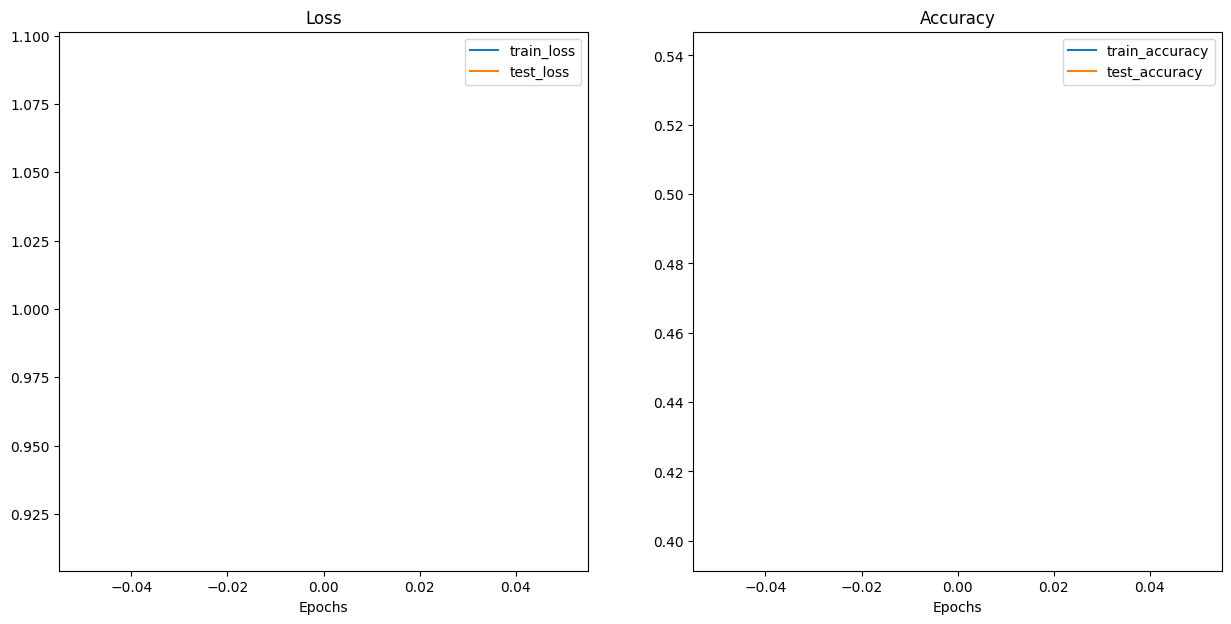

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
# The y_preds variable is a list of tensors.
# We need to concatenate them into a single tensor using torch.cat().
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-63-5cd8ff84f3a2>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred_tensor)


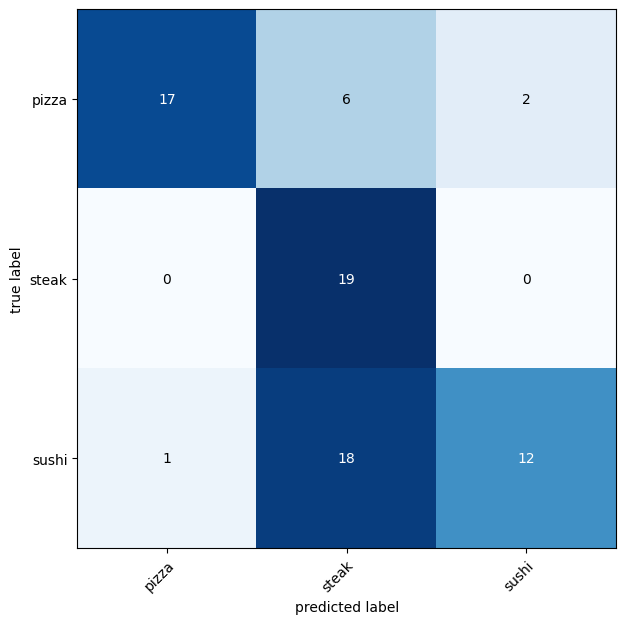

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
y_pred_tensor = torch.tensor(y_pred_tensor)
y_true_tensor = torch.tensor(test_dataloader.dataset.targets)

# Now use them
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)



# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
from torch.nn import functional as F
model.eval()

all_preds =[]
all_probs =[]
all_labels =[]

with torch.no_grad():
  for X, y in tqdm(test_dataloader):

    X, y = X.to(device), y.to(device)

    logit = model(X)
    probs = torch.softmax(logit, dim=1)
    preds = torch.argmax(probs,dim=1)

    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())
    all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
wrong_mask = all_preds != all_labels


In [ ]:
pred_confidences = all_probs[torch.arange(len(all_preds)), all_preds]


In [ ]:
wrong_preds = all_preds[wrong_mask]
wrong_labels = all_labels[wrong_mask]
wrong_probs = all_probs[wrong_mask]
wrong_confidences = pred_confidences[wrong_mask]


In [ ]:
sorted_indices = torch.argsort(wrong_confidences, descending=True)


In [ ]:
most_wrong_preds = wrong_preds[sorted_indices]
most_wrong_labels = wrong_labels[sorted_indices]
most_wrong_probs = wrong_probs[sorted_indices]
most_wrong_confidences = wrong_confidences[sorted_indices]


In [ ]:
num_to_plot = 5
plt.figure(figsize=(15, 7))


<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

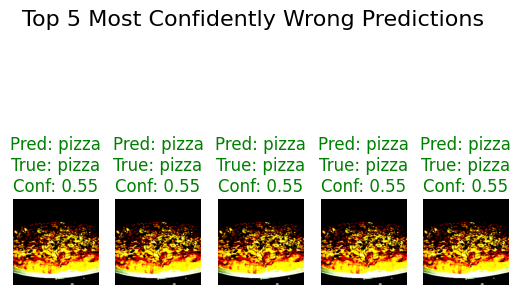

In [ ]:
for i in range(num_to_plot):
  idx = most_wrong_confidences[i].int().item()
  img, label = test_dataloader.dataset[idx]
  pred = all_preds[idx].item()
  true = all_labels[idx].item()
  conf = all_probs[idx][pred].item()

  plt.subplot(1, num_to_plot, i + 1)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}\nConf: {conf:.2f}",
              color='red' if pred != true else 'green')
  plt.axis('off')

plt.suptitle("Top 5 Most Confidently Wrong Predictions", fontsize=16)
plt.show()


In [ ]:
custom_image_path = "/content/download (14).jpg"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))


print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[57, 55, 60,  ...,  3,  3,  3],
         [53, 57, 55,  ...,  3,  3,  3],
         [47, 59, 64,  ...,  3,  3,  3],
         ...,
         [18, 18, 18,  ..., 15, 14, 20],
         [18, 18, 18,  ..., 15, 14, 11],
         [19, 17, 15,  ..., 17, 17, 13]],

        [[56, 54, 59,  ...,  3,  3,  3],
         [52, 56, 54,  ...,  3,  3,  3],
         [46, 58, 63,  ...,  3,  3,  3],
         ...,
         [18, 18, 18,  ..., 15, 14, 20],
         [18, 18, 18,  ..., 15, 14, 11],
         [19, 17, 15,  ..., 17, 17, 13]],

        [[62, 60, 65,  ...,  3,  3,  3],
         [58, 62, 60,  ...,  3,  3,  3],
         [52, 64, 69,  ...,  3,  3,  3],
         ...,
         [20, 20, 20,  ..., 17, 16, 22],
         [20, 20, 20,  ..., 17, 16, 13],
         [21, 19, 17,  ..., 17, 17, 15]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 225, 225])

Custom image dtype: torch.uint8


In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)


custom_image = custom_image / 255.


print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.2235, 0.2157, 0.2353,  ..., 0.0118, 0.0118, 0.0118],
         [0.2078, 0.2235, 0.2157,  ..., 0.0118, 0.0118, 0.0118],
         [0.1843, 0.2314, 0.2510,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.0588, 0.0549, 0.0784],
         [0.0706, 0.0706, 0.0706,  ..., 0.0588, 0.0549, 0.0431],
         [0.0745, 0.0667, 0.0588,  ..., 0.0667, 0.0667, 0.0510]],

        [[0.2196, 0.2118, 0.2314,  ..., 0.0118, 0.0118, 0.0118],
         [0.2039, 0.2196, 0.2118,  ..., 0.0118, 0.0118, 0.0118],
         [0.1804, 0.2275, 0.2471,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.0588, 0.0549, 0.0784],
         [0.0706, 0.0706, 0.0706,  ..., 0.0588, 0.0549, 0.0431],
         [0.0745, 0.0667, 0.0588,  ..., 0.0667, 0.0667, 0.0510]],

        [[0.2431, 0.2353, 0.2549,  ..., 0.0118, 0.0118, 0.0118],
         [0.2275, 0.2431, 0.2353,  ..., 0.0118, 0.0118, 0.0118],
         [0.2039, 0.2510, 0.2706,  ..

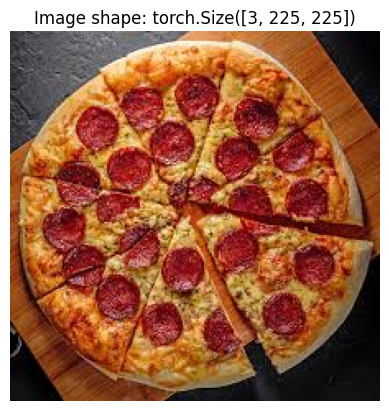

In [ ]:

plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:

custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])


custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 225, 225])
New shape: torch.Size([3, 64, 64])


In [ ]:
model.eval()
with torch.inference_mode():

    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)


    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")


    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [ ]:
custom_image_pred

tensor([[ 0.2516, -0.0711, -0.0776]], device='cuda:0')

In [ ]:

print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")


custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.2516, -0.0711, -0.0776]], device='cuda:0')
Prediction probabilities: tensor([[0.4092, 0.2963, 0.2944]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [ ]:

custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'pizza'

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()


results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8151 | train_acc: 0.8398 | test_loss: 0.8193 | test_acc: 0.7955
[INFO] Total training time: 2.175 seconds


In [ ]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"


if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)


with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [ ]:
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor()
])

In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_data_20_percent_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_data_20_percent_path,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi_20_percent/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi_20_percent/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_data,
                                     batch_size=1,
                                     num_workers=0,

                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data,
                                    batch_size=1,

                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x786e9f9a3750>,
 <torch.utils.data.dataloader.DataLoader at 0x786e9fac59d0>)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()


results = train(model=model,
                       train_dataloader=train_dataloader_custom,
                       test_dataloader=test_dataloader_custom,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1598 | train_acc: 0.3200 | test_loss: 17.1026 | test_acc: 0.3333
[INFO] Total training time: 9.406 seconds


In [ ]:

weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model1 = torchvision.models.efficientnet_b2(weights=weights).to(device)




Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 117MB/s]


In [ ]:

summary(model=model1,
        input_size=(32, 3, 224, 224),

        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:

for param in model1.features.parameters():
    param.requires_grad = False

In [ ]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)

model1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:

summary(model1,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()


results = train(model=model1,
                       train_dataloader=train_dataloader_custom,
                       test_dataloader=test_dataloader_custom,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1678 | train_acc: 0.3444 | test_loss: 4.2870 | test_acc: 0.3733
[INFO] Total training time: 12.710 seconds
